Calculates Trading Stats based on Trading View Account History exports in order to derive actionable insights. 
A sample dataset from a strategy under development has been attached for testing purposes

In [ ]:
import pandas as pd
# Define the file path
file_path = r"C:\Users\prath\Desktop\Quant\4. Data\TV Paper Trading\ES (10.2.25 - 14.2.25).csv"
df = pd.read_csv(file_path)

'''# OPTIONAL Define the time range for analysis
start_date = "2025-01-25"  # (YYYY-MM-DD)
end_date = "2025-02-09"    # (YYYY-MM-DD)
df = df[(df['Time'] >= start_date) & (df['Time'] <= end_date)]
'''
# Display the first few rows
print(df.head())
print("\n")  
print(df.tail())

                  Time  Balance Before  Balance After  Realized P&L (value)  \
0  2025-02-14 16:48:15    105772.54849   106960.04849                1187.5   
1  2025-02-14 14:48:38    106072.54849   105772.54849                -300.0   
2  2025-02-14 14:44:36    106260.04849   106072.54849                -187.5   
3  2025-02-14 14:30:12    105447.54849   106260.04849                 812.5   
4  2025-02-14 14:10:39    106197.54849   105447.54849                -750.0   

  Realized P&L (currency)                                             Action  
0                     USD  Close short position for symbol CME_MINI:ES1! ...  
1                     USD  Close long position for symbol CME_MINI:ES1! a...  
2                     USD  Close short position for symbol CME_MINI:ES1! ...  
3                     USD  Close short position for symbol CME_MINI:ES1! ...  
4                     USD  Close short position for symbol CME_MINI:ES1! ...  


                    Time  Balance Before  Balance

In [ ]:
# Convert 'Time' column to datetime format
df['Time'] = pd.to_datetime(df['Time'])

# Extract trade type (Long or Short) from the 'Action' column
df['Trade Type'] = df['Action'].apply(lambda x: 'Long' if 'long' in x.lower() else 'Short')

# Calculate Trade P&L
df['P&L'] = df['Balance After'] - df['Balance Before']

# Calculate key performance metrics
total_trades = len(df)
winning_trades = df[df['P&L'] > 0]
losing_trades = df[df['P&L'] < 0]
win_rate = len(winning_trades) / total_trades * 100
avg_profit = winning_trades['P&L'].mean()
avg_loss = losing_trades['P&L'].mean()
profit_factor = winning_trades['P&L'].sum() / abs(losing_trades['P&L'].sum())
sharpe_ratio = df['P&L'].mean() / df['P&L'].std()

df = df.sort_values(by='Time', ascending=True).reset_index(drop=True)
df['Peak Balance'] = df['Balance After'].cummax()  # Track highest balance over time
df['Drawdown'] = df['Peak Balance'] - df['Balance After']  # Absolute drawdown
max_drawdown = df['Drawdown'].max()  # Get the largest drawdown

# Analyze Long vs. Short performance
long_trades = df[df['Trade Type'] == 'Long']
short_trades = df[df['Trade Type'] == 'Short']
long_win_rate = len(long_trades[long_trades['P&L'] > 0]) / len(long_trades) * 100
short_win_rate = len(short_trades[short_trades['P&L'] > 0]) / len(short_trades) * 100

# Performance by Hour of the Day
df['Hour'] = df['Time'].dt.hour
hourly_performance = df.groupby('Hour')['P&L'].sum()

# Performance by Day of the Week
df['Day of Week'] = df['Time'].dt.day_name()
daily_performance = df.groupby('Day of Week')['P&L'].sum()

# Consecutive Wins/Losses
df['Win'] = df['P&L'] > 0
df['Streak'] = df['Win'].groupby((df['Win'] != df['Win'].shift()).cumsum()).cumcount() + 1
max_win_streak = df[df['Win']].Streak.max()
max_loss_streak = df[~df['Win']].Streak.max()

# Weekly & Monthly Performance Summary
df['Week'] = df['Time'].dt.strftime('%Y-%U')
df['Month'] = df['Time'].dt.strftime('%Y-%m')
weekly_performance = df.groupby('Week')['P&L'].sum()
monthly_performance = df.groupby('Month')['P&L'].sum()



# P&L Breakdown by Trade Size
import numpy as np
import re
# Function to extract trade size from 'Action' column
def extract_trade_size(action_text):
    match = re.search(r'(\d+)\s+units', action_text)  # Find a number before 'units'
    return int(match.group(1)) if match else None  # Convert to integer if found
# Apply function to extract trade size

df['Trade Size'] = df['Action'].apply(extract_trade_size)

# Compute Dynamic Trade Size Bins (Using Percentiles)
quantiles = np.percentile(df['Trade Size'], [0, 25, 50, 75, 100])  # Min, Q1, Median, Q3, Max
trade_size_bins = np.unique(quantiles) # Ensure unique bin edges (Avoid duplicates)
# Generate Labels Dynamically
trade_size_labels = [f"{int(trade_size_bins[i])}-{int(trade_size_bins[i+1])}" for i in range(len(trade_size_bins)-1)]
# Categorize Trades Based on Dynamic Bins
df['Trade Size Category'] = pd.cut(df['Trade Size'], bins=trade_size_bins, labels=trade_size_labels, include_lowest=True)
#Compute P&L for Each Trade Size Category
trade_size_performance = df.groupby('Trade Size Category')['P&L'].sum()

# Compute Trade Count for Each Category
trade_size_count = df.groupby('Trade Size Category').size()
hourly_trade_count = df.groupby('Hour').size()
daily_trade_count = df.groupby('Day of Week').size()
weekly_trade_count = df.groupby('Week').size()
monthly_trade_count = df.groupby('Month').size()


# Display Results
print("\n--- Key Performance Metrics ---")
print(f"Total Trades: {total_trades}")
print(f"Win Rate: {win_rate:.2f}%")
print(f"Average Profit Per Trade: ${avg_profit:.2f}")
print(f"Average Loss Per Trade: ${avg_loss:.2f}")
print(f"Profit Factor: {profit_factor:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Max Drawdown: ${max_drawdown:.2f}")
print(f"Max Winning Streak: {max_win_streak}")
print(f"Max Losing Streak: {max_loss_streak}")

print("\n--- Long vs. Short Performance ---")
print(f"Win Rate (Longs): {long_win_rate:.2f}%")
print(f"Win Rate (Shorts): {short_win_rate:.2f}%")




--- Key Performance Metrics ---
Total Trades: 132
Win Rate: 47.73%
Average Profit Per Trade: $377.10
Average Loss Per Trade: $-254.62
Profit Factor: 1.41
Sharpe Ratio: 0.11
Max Drawdown: $4747.22
Max Winning Streak: 5
Max Losing Streak: 7

--- Long vs. Short Performance ---
Win Rate (Longs): 50.00%
Win Rate (Shorts): 45.71%


C:\Users\prath\AppData\Local\Temp\ipykernel_69468\3731882236.py:72: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  trade_size_performance = df.groupby('Trade Size Category')['P&L'].sum()
C:\Users\prath\AppData\Local\Temp\ipykernel_69468\3731882236.py:75: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  trade_size_count = df.groupby('Trade Size Category').size()


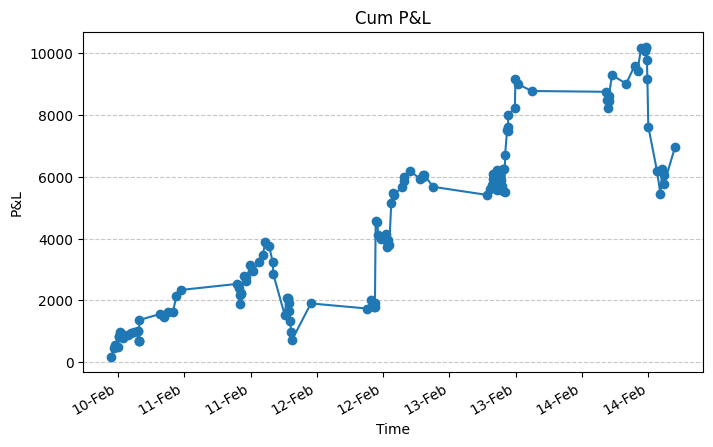

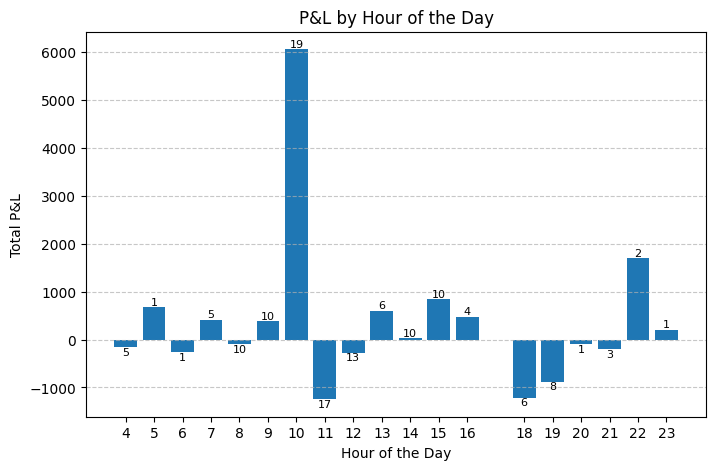

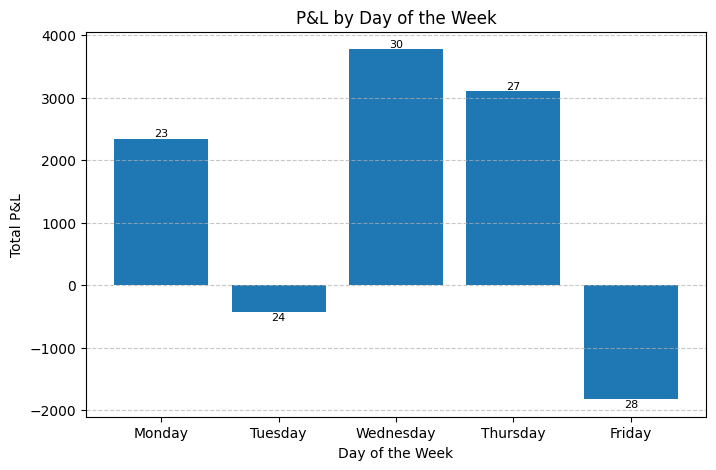

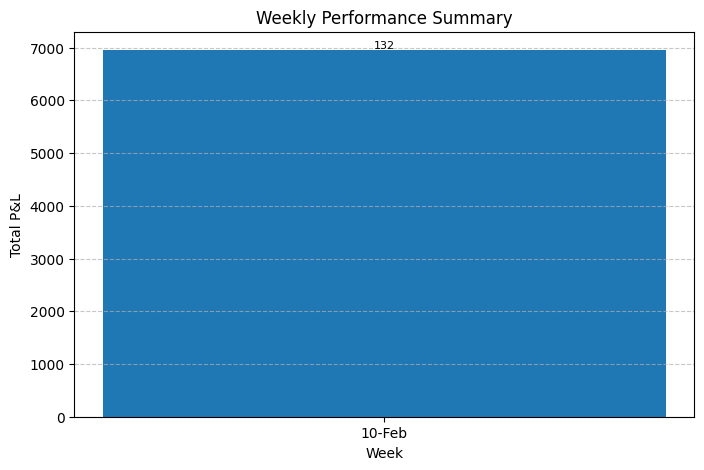

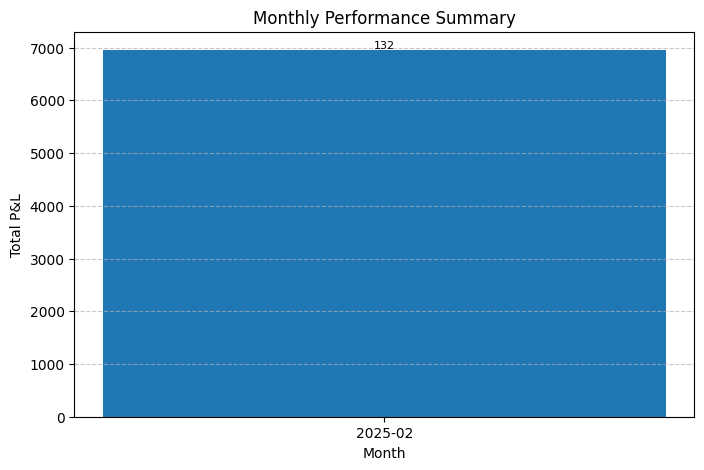

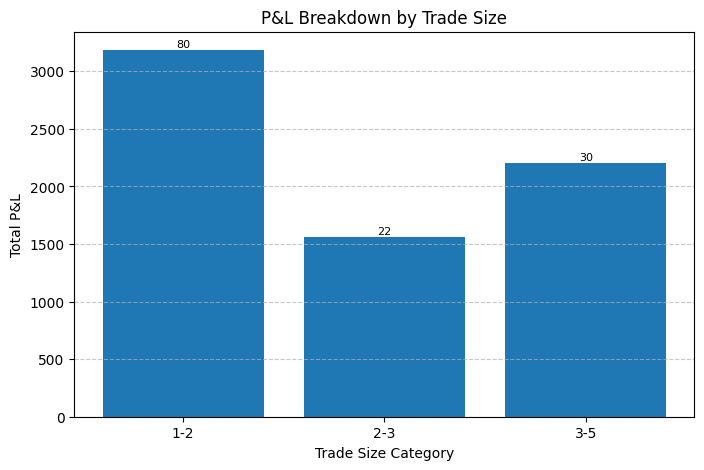

In [23]:
# Visualize Balance Over Time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- Function to Add Trade Number Annotations ---
def add_annotations(ax, x_values, y_values, trade_counts):
    """ Adds trade count annotations above bars, adjusting for negatives. """
    for x, y, count in zip(x_values, y_values, trade_counts):
        if y >= 0:
            ax.text(x, y + 3, f"{count}", ha='center', va='bottom', fontsize=8, color='black')
        else:
            ax.text(x, y - 3, f"{count}", ha='center', va='top', fontsize=8, color='black')  # Adjusted for negatives


# --- P&L Curve ---
fig, ax = plt.subplots(figsize=(8, 5)) 
ax.plot(df['Time'], df['P&L'].cumsum(), label='Cumulative P&L', marker='o')
ax.set_title('Cum P&L')
ax.set_xlabel('Time')
ax.set_ylabel('P&L')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))  # Change date format
fig.autofmt_xdate() # Rotate x-axis labels for better readability 
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# --- P&L by Hour of the Day ---
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(hourly_performance.index, hourly_performance.values)
add_annotations(ax, hourly_performance.index, hourly_performance.values, hourly_trade_count)
ax.set_xlabel("Hour of the Day")
ax.set_ylabel("Total P&L")
ax.set_title("P&L by Hour of the Day")
ax.set_xticks(hourly_performance.index)  # Ensure all hours are shown
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# --- P&L by Day of the Week ---
fig, ax = plt.subplots(figsize=(8, 5))
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_performance = daily_performance.reindex(day_order)  # Reorder for correct sequence
ax.bar(daily_performance.index, daily_performance.values) 
add_annotations(ax, daily_performance.index, daily_performance.values, daily_trade_count)
ax.set_xlabel("Day of the Week")
ax.set_ylabel("Total P&L")
ax.set_title("P&L by Day of the Week")
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# --- Weekly Performance Summary ---
fig, ax = plt.subplots(figsize=(8, 5))
weekly_performance.index = pd.to_datetime(weekly_performance.index + '-1', format='%Y-%U-%w')
ax.bar(weekly_performance.index, weekly_performance.values, width=5)
add_annotations(ax, weekly_performance.index, weekly_performance.values, weekly_trade_count)
ax.set_xticks(weekly_performance.index, weekly_performance.index.strftime('%d-%b'))  # Show as dd-mmm
ax.set_xlabel("Week")
ax.set_ylabel("Total P&L")
ax.set_title("Weekly Performance Summary")
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# --- Monthly Performance Summary ---
fig, ax = plt.subplots(figsize=(8, 5)) 
ax.bar(monthly_performance.index, monthly_performance.values)
add_annotations(ax, monthly_performance.index, monthly_performance.values, monthly_trade_count)
ax.set_xlabel("Month")
ax.set_ylabel("Total P&L")
ax.set_title("Monthly Performance Summary")
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# --- P&L Breakdown by Trade Size ---
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(trade_size_performance.index.astype(str), trade_size_performance.values)
add_annotations(ax, trade_size_performance.index.astype(str), trade_size_performance.values, trade_size_count)
ax.set_xlabel("Trade Size Category")
ax.set_ylabel("Total P&L")
ax.set_title("P&L Breakdown by Trade Size")
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

The analysis indicates a profit factor of 1.41, suggesting a positive expectancy, but the Sharpe ratio of 0.11 highlights the need for better volatility management to achieve more consistent returns. Additionally, the max drawdown of $4,747.22 relative to individual trade risk signals inefficient capital allocation, reinforcing the need to refine risk management strategies to improve overall stability and performance.
